# Analyze Satisfaction Survey Responses

An example demonstration of a typical analysis workflow in DSX leveraging Spark, Watson APIs, Pandas, and various visualization libraries.

<img src='https://www-935.ibm.com/services/image/watson_data_platform_banner_running.jpg' width="100%" height="50%"></img>


## Code Toggle

Hide code cells for cleaner output with a selectable toggle.  

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Import packages to the notebook

Import the `requests`, `base64`, `StringIO`, `pandas`, `SparkContext`, `json`, and `re` packages to use in the notebook. The  pandas package is traditionally imported as `pd`: 

In [2]:
import nltk, requests, StringIO, pandas as pd, pprint, json, re, sys
from pyspark import SparkContext
from pixiedust.display import *

!pip install wordcloud --user nltk
from wordcloud import WordCloud, STOPWORDS

Pixiedust database opened successfully


###  Access Object Storage

Because the `surveys.csv` file is located in Object Storage, you need to define a helper function to access the data file that you loaded. Run the following cell to define the method `get_file_content()`:

### Insert data source credentials

The credentials for accessing the `surveys.csv` file are added to the cell in a function. With these credentials, you can use the helper function to load the data file into a `pandas.DataFrame`. 

**Note**: When you select the `Insert to code` function, a code cell with a dictionary is created for you.  Adjust the credentials in the Python dictionary to correspond with the credentials inserted by the `Insert to code` function and run the dictionary code cell. The access credentials to the Object Storage instance in the dictionary are provided for convenience for later usage. 

In [4]:
# The code was removed by DSX for sharing.

In [ ]:
# The code was removed by DSX for sharing.

### Load data into `pandas DataFrame`

Run the next cell to load the data into a pandas DataFrame: 

In [5]:
surveys_df = pd.read_csv(get_object_storage_file_with_credentials_bba657a78df141959b30542141270d03('WSUSymposium', 'surveys.csv'))

<a id="explore_data"></a> 
## 4. Explore data

Show the first five and the last five rows of the data by using the `head()` and `tail()` methods.  Run each code cell:

In [6]:
surveys_df.head()

,SectionName,dept,CommentText
0,Room,a03a76f447a2a78a14c420968b7d6321b903bc18d6d090...,"They cleaned at night time, they were fast & q..."
1,Meals,a03a76f447a2a78a14c420968b7d6321b903bc18d6d090...,The salads were good. Some of the main entree...
2,Tests and Treatment,a03a76f447a2a78a14c420968b7d6321b903bc18d6d090...,They asked if I understood & if it was OK to p...
3,Personal Issues,a03a76f447a2a78a14c420968b7d6321b903bc18d6d090...,The nurses were very helpful & caring. Treate...
4,Meals,aa79e7b740b862d35591300ccd06885f864eb2160222b8...,Limited selection. Hours of availability.


In [7]:
surveys_df.tail()

,SectionName,dept,CommentText
995,Meals,ab9d1b895c331418376465a13e9a49224c817e0ef90c91...,Tray had regular items - when I was to get dia...
996,Personal Issues,ab9d1b895c331418376465a13e9a49224c817e0ef90c91...,Any problems fixed at once.
997,Meals,538671ce4a524e33b0585dfb298a50f06e35f68ccf0c39...,Always on time.
998,Room,538671ce4a524e33b0585dfb298a50f06e35f68ccf0c39...,Didn't mop floors only change trash.
999,Personal Issues,538671ce4a524e33b0585dfb298a50f06e35f68ccf0c39...,Nurses on B1 are great.


Each row in the table lists:

* The facility where the survey was done.
* The type of survey involved.

## Unique Facilities

How many discrete facilities are captured in our dataset?  

In [8]:
surveys_df.dept.unique()

array(['a03a76f447a2a78a14c420968b7d6321b903bc18d6d090f26205ca784e9fd730',
       'aa79e7b740b862d35591300ccd06885f864eb2160222b83107f7c7493153af63',
       'fc8e9a93208787d3385777da843db934c2a6babbca89c500f06b0ea2a4b34daa',
       'b148428966e70b9778ea073168b1f0c0ccc1b8bfd7027a6641835e9200920ba7',
       'ce34e185e1085451ec06d40a63363886a643b7ab102ac8c236dee51c2cc238da',
       'ab9d1b895c331418376465a13e9a49224c817e0ef90c91d1d2b70795177fb5aa',
       'dbbfc0fe8bcca58ae13a3d6c997cd353dfe7b90202dbc6ab4c7af3d28bc94711',
       '82c07801023ca5caad6fb81bb5958dbf3d095191c226a4d512e125b4aaa16506',
       '3e4423f2c0fea026561654892fb2025f52549af39a8bf7c7e8669f47145cb3d2',
       'fbf29199bce1917852dcc5d2f9851f592d416d7abfee22688c5ada60e6367e8f',
       'a7865dc86bb17f592d5ba2ac3deeb93b5c68496b97463c8343f2670e710b0467',
       'af80202c5afd453e7f482e264c89fe1f07dd463612aa9f7e2d453dfcf26c62c4',
       'fd4a711ed9bde9026f91d73c201c94611156e36cf3793f8c6e1b66a95f7cc795',
       '12fb53bbe147bfe9b

## Unique Survey Sections

Let's identify the unique survey categories of response.  

In [9]:
surveys_df.SectionName.unique()

array(['Room', 'Meals', 'Tests and Treatment', 'Personal Issues'], dtype=object)

## Data Transformations

Now that we have a basic understanding of our data we will want to move through the data and clean it up for easier prcoessing of our sentiment and tonal analysis.  

### Lowercase

Convert to comments to lowercase.

In [10]:
surveys_df['CommentText'] = surveys_df['CommentText'].str.lower()
surveys_df.head()

,SectionName,dept,CommentText
0,Room,a03a76f447a2a78a14c420968b7d6321b903bc18d6d090...,"they cleaned at night time, they were fast & q..."
1,Meals,a03a76f447a2a78a14c420968b7d6321b903bc18d6d090...,the salads were good. some of the main entree...
2,Tests and Treatment,a03a76f447a2a78a14c420968b7d6321b903bc18d6d090...,they asked if i understood & if it was ok to p...
3,Personal Issues,a03a76f447a2a78a14c420968b7d6321b903bc18d6d090...,the nurses were very helpful & caring. treate...
4,Meals,aa79e7b740b862d35591300ccd06885f864eb2160222b8...,limited selection. hours of availability.


### Remove Punctuation and Whitespace and Stopwords

Let's remove punctuation and whitespace so we can omit them from our analysis.  We should also remove common words from our analysis for term frequencies.

In [11]:
nltk.download("stopwords")

def removePunctuation(text):
    """Removes punctuation, changes to lowercase, and strips leading and trailing spaces.
    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated. (e.g. it's becomes its)
    Args:
        text (str): A string.
    Returns:
        str: The cleaned up string.
    """
    letters_only = re.sub("[^a-zA-Z]", " ", text) 
    words = letters_only.lower().split()
    return(words)

def removeWords(text):
    from nltk.corpus import stopwords # Import the stop word list
    """Removes punctuation, changes to lowercase, and strips leading and trailing spaces.
    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated. (e.g. it's becomes its)
    Args:
        text (str): A string.
    Returns:
        str: The cleaned up string.
    """
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in text if not w in stops]
    return(" ".join(meaningful_words))

surveys_df['CommentText'] = surveys_df['CommentText'].apply(removePunctuation)

surveys_df_trim = surveys_df

surveys_df_trim['CommentText'] = surveys_df['CommentText'].apply(removeWords)

[nltk_data] Downloading package stopwords to /gpfs/fs01/user/sa40-8977
[nltk_data]     00f6b3fee3-ac63c96e2357/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Indexes

Let's build an index by dept so we can summarize all surveys together easier.

In [12]:
surveys_df = surveys_df.set_index(surveys_df["dept"])
surveys_df.drop(['dept'], axis=1, inplace=True)

## Convert to Spark Data Frame from Pandas

So far we've explored the data and performed several manipulations in Pandas.  Pandas is a great library, but it will not provide us with the distributed computing facilities we require for large scale analysis.  Let's move this into Spark and see what we can work with.  

Once in Spark we can visualize our dataset with the excellent Pixiedust library by IBM.

In [30]:
from pyspark.sql import SQLContext
print sc
sqlCtx = SQLContext(sc)
spark_df = sqlCtx.createDataFrame(surveys_df)

display(spark_df)

SectionName,CommentText
Room,cleaned night time fast quiet
Meals,salads good main entrees kinda dry bland
Tests and Treatment,asked understood ok proceed
Personal Issues,nurses helpful caring treated like person work
Meals,limited selection hours availability
Tests and Treatment,lost pounds days limited dinners lunch box meals due testing duration awaiting results diabetic type one meal per day unsatisfactory unhealthy inadequate stay stressful
Personal Issues,spent considerable time wheelchair waiting tested administrative office nuclear imaging associate bragging pictures mouse took w cell phone roaming wing mouse came kitchen via vent duct
Room,cleaning lady always courteous
Meals,meals good think lot taste factor due meds
Tests and Treatment,always knew tests never wait long


## Counts of Surveys by Section

Let's graph some basic counts of surveys with Pixiedust.  Note how you can change the graph type graphically.

In [ ]:
countsBySection = spark_df.groupby("SectionName").count()
display(countsBySection)

In [16]:
import brunel

words = spark_df.select("CommentText").rdd.map(lambda r: r[0])
counts = words.flatMap(lambda line: re.split('\W+', line.lower().strip())) \
            .filter(lambda x: len(x) > 2) \
            .map(lambda word: (word, 1)) \
            .reduceByKey(lambda a, b: a + b) \
            .map(lambda x: (x[1], x[0])).sortByKey(False) \
            .map(lambda x: (x[1], x[0]))

counts_df = pd.DataFrame(counts.take(10))
#counts_df = counts_df.transpose()
cols = ['Word', 'Count']
counts_df.columns = cols

%brunel data('counts_df') bar x(Word) y(Count) sort(Count) transpose :: width=800, height=640

<IPython.core.display.Javascript object>

## Machine Learning

Now that we have an idea of our data, we can move into our actual modeling and analysis.  An interesting thought exercise might be to determine what words are mostly associated with a good sentiment or a bad sentiment.  

We will use the Spark MLlib library Word2Vec to find the cosine distance synonyms for terms 'good' and 'bad'.  

In [17]:
from pyspark.mllib.feature import Word2Vec

inp = words.map(lambda row: row.split(" "))

word2vec = Word2Vec()
model = word2vec.fit(inp)

In [18]:
synonyms = model.findSynonyms('good', 40)

for word, cosine_distance in synonyms:
  print "{}: {}".format(word, cosine_distance)

experience: 0.154700975025
overall: 0.139902208244
person: 0.125978767417
job: 0.122228895409
friendly: 0.104854554968
experiences: 0.103755003973
treatment: 0.101109680611
clean: 0.0980236286156
surgery: 0.0972694884535
kind: 0.0951914662681
housekeeping: 0.0942276150766
op: 0.0926265801651
except: 0.0914596729724
nice: 0.0906748621121
issues: 0.0821827491352
pleased: 0.0809665851722
regular: 0.0796751967927
tell: 0.0794185167154
pre: 0.0786618170825
min: 0.0760293282459
feel: 0.075414744987
high: 0.07199356965
minutes: 0.071883983945
med: 0.0713922533721
testing: 0.0703375929525
expected: 0.0685623880491
issue: 0.0665094503288
mri: 0.0664965070635
stayed: 0.0663873692741
work: 0.0645797717881
negative: 0.0623261164327
certain: 0.0553267515788
attention: 0.0538616615342
young: 0.0533679422343
main: 0.0503007568226
b: 0.050099922875
many: 0.0492043835877
taking: 0.0490165040064
let: 0.0474340708565
emergency: 0.0467366621862


### Most Associated Good Synonyms

In [20]:
values = map(lambda x: x[1], synonyms)
labels = map(lambda x: x[0], synonyms)

syn_df = pd.DataFrame(synonyms)
cols = ['term', 'score']
syn_df.columns = cols

%brunel data('syn_df') bar x(term) y(score) sort(score) transpose :: width=800, height=640

<IPython.core.display.Javascript object>

### Word Clouds

Word clouds are a nice human way to understand the relationship and weighting of sentiment in a free text field.  They're not scientific, but they do help us to dig deeper.

#### Word Clouds for Good Terms

/usr/local/src/bluemix_jupyter_bundle.v36/notebook/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/usr/local/src/bluemix_jupyter_bundle.v36/notebook/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/usr/local/src/bluemix_jupyter_bundle.v36/notebook/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/usr/local/src/bluemix_jupyter_bundle.v36/notebook/lib/python2.7/

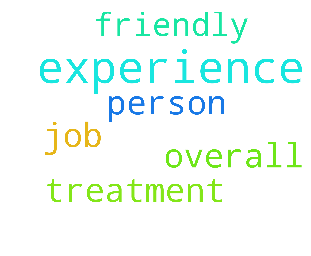

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

!pip install wordcloud --user nltk
from wordcloud import WordCloud, STOPWORDS


wordList = " ".join([x[0] for x in synonyms for times in range(0, int(x[1]*10))])
 
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      relative_scaling=.5,
                      width=2400,
                      height=2000,
                     ).generate(wordList)
 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Most Associated Bad Synonyms

In [22]:
synonyms = model.findSynonyms('bad', 10)

for word, cosine_distance in synonyms:
  print "{}: {}".format(word, cosine_distance)

food: 0.0710959105657
know: 0.0695198505295
took: 0.0688279619572
room: 0.0682156205261
say: 0.0678251663028
hospital: 0.0677300174278
people: 0.0676665933298
meals: 0.0676526559983
complaints: 0.0672124836255
best: 0.0666773356456


In [23]:
values = map(lambda x: x[1], synonyms)
labels = map(lambda x: x[0], synonyms)

syn_df = pd.DataFrame(synonyms)
cols = ['term', 'score']
syn_df.columns = cols

%brunel data('syn_df') bar x(term) y(score) sort(score) transpose :: width=800, height=640

<IPython.core.display.Javascript object>

### Watson Tonal Analysis

Sentiment analysis is relatively trivial at this stage, and most survey vendors provide a basic NLP implementation.  I feel we can go deeper and perhaps find a larger insight with more sophisticated analysis.  Let's leverage IBM's Watson ML platform via RESTful API calls and see what we can determine.  

Tone Analyzer uses linguistic analysis to detect three types of tones in written text: emotions, social tendencies, and writing style. Use the Tone Analyzer service to understand emotional context of conversations and communications. Use this insight to respond in an appropriate manner.

In [31]:
!pip install watson_developer_cloud --user nltk

import json
from watson_developer_cloud import ToneAnalyzerV3

tone_analyzer = ToneAnalyzerV3(
    username='e6eb62c2-cb6f-4036-9ad8-666afd8cd185',
    password='wxoRyaPj1d4m',
    version='2016-02-11')

toneRows = spark_df.select("CommentText").take(100)

tones = []

for r in toneRows:
    tones.append(json.dumps(tone_analyzer.tone(text=str(r)), indent=2))

In [27]:
from collections import defaultdict

score_list = defaultdict(list)

# Build Dict of Tonal Scores
for i in tones:
    data = json.loads(str(i))
    for r in data['document_tone']['tone_categories']:
        for score in r['tones']:
            score_list[score['tone_name']].append(score['score'])

# Average Tonal Sentiment by Tone Category
avgDict = {}
for k,v in score_list.iteritems():
    # v is the list of grades for student k
    avgDict[k] = sum(v)/ float(len(v))
print("Tone Category Averages")
print(json.dumps(avgDict, indent=2))
            
# Display Tonal Scores Human Readable
for i in tones:
    data = json.loads(str(i))
    for r in data['document_tone']['tone_categories']:
        print(r['category_name'])
        print("-" * len(r['category_name']))
        for j in r['tones']:
            print(j['tone_name'].ljust(20),(str(round(j['score'] * 100,1)) + "%").rjust(10))
        print()

Tone Category Averages
{
  "Disgust": 0.18007970000000004, 
  "Tentative": 0.15502543, 
  "Emotional Range": 0.1244288499999999, 
  "Joy": 0.15822116999999997, 
  "Sadness": 0.29244264999999997, 
  "Confident": 0.15959028, 
  "Extraversion": 0.4587855200000001, 
  "Agreeableness": 0.58267708, 
  "Conscientiousness": 0.22149726000000006, 
  "Openness": 0.14541356000000005, 
  "Analytical": 0.03888428, 
  "Anger": 0.23846152000000007, 
  "Fear": 0.12431748000000002
}
Emotion Tone
------------
(u'Anger               ', '     11.5%')
(u'Disgust             ', '     13.6%')
(u'Fear                ', '     21.8%')
(u'Joy                 ', '     30.9%')
(u'Sadness             ', '     13.0%')
()
Writing Tone
------------
(u'Analytical          ', '      0.0%')
(u'Confident           ', '      0.0%')
(u'Tentative           ', '      0.0%')
()
Social Tone
-----------
(u'Openness            ', '      0.2%')
(u'Conscientiousness   ', '     21.0%')
(u'Extraversion        ', '     53.2%')
(u'Agree

## Thank you for your time!

In [ ]:
import requests

url = 'https://kafka-rest-prod01.messagehub.services.us-south.bluemix.net:443/topics/sentiment'

headers = {'Content-type': 'application/vnd.kafka.json.v1+json',
           'X-Auth-Token': '0voZA4gXyOWP4ORu0LxarghaHMZaDwI0eDErLGoYyAProwgB'}

response = requests.put(url, data=tones[0], headers=headers)

print(response)

In [ ]:
response = requests.get('https://kafka-rest-prod01.messagehub.services.us-south.bluemix.net:443/topics/sentiment', headers)
print(response)

In [ ]:
spark_df.saveAsParquetFile("swift://notebooks.spark/surveys.parquet")